## Pareto Front - стохастические алгоритмы

Итак, многофакторная оптимизация может состоять из двух стадий:

- Формирование [границы Парето](20230407-pareto-front.ipynb).
- Последующий экспертный анализ, например, с использованием [визуализаций](20230410-pareto-front-heatmaps.ipynb).

В предыдущих блокнотах ([первый](20230407-pareto-front.ipynb), [второй](20230410-pareto-front-heatmaps.ipynb)) я действовал методом полного перебора (brute force). На небольшом объёме заранее рассчитанных данных это оправдано. В реальности же вычисление целевых функций может быть затратным. Например, для каждого сочетания параметров приходится запускать симуляцию или даже физический эксперимент.

Поэтому применяют [стохастические](https://ru.wikipedia.org/wiki/Стохастический) стратегии обхода.

### Случайный поиск

Самый банальный вариант - итеративно перебирать рандомные параметры до достижения либо таймаута, либо определённой плотности покрытия.

<!--more-->

Давайте попробуем. Возьмём демонстрационные данные из [предыдущего эксперимента](20230410-pareto-front-heatmaps.ipynb):


In [1]:
import numpy as np
data = np.genfromtxt('data/5d-in.tsv')

# Унифицируем направление оптимизации в сторону максимума
data = np.array([
    [-f[0], -f[1], f[2], -f[3], -f[4]] for f in data
])


Напомню, это таблица из 5 колонок - 2 аргумента, 3 целевые функции. Все значения являются факторами оптимизации.

Аргументы будем обозначать буквой `x`, а факторы буквой `f`.

Ниже понадобятся две вспомогательные операции. Первая - `x_to_f`, "дай факторы по аргументам". Её оформим через словарь:

In [2]:
x_to_f = {(f[0], f[1]): f for f in data}


Вторая операция - обратная `f_to_x`:

In [3]:
def f_to_x(f):
    return (f[0], f[1])


Поскольку у нас все аргументы являются факторами, их можно достать напрямую. В общем случае пришлось бы заполнять обратный словарь по ходу перебора.

Ещё пригодятся границы допустимых значений аргументов:

In [4]:
min_x0 = min(data[:, 0])
max_x0 = max(data[:, 0])
min_x1 = min(data[:, 1])
max_x1 = max(data[:, 1])
(min_x0, max_x0), (min_x1, max_x1)


((-5.0, -1.0), (-3.0, -1.0))

Фиксируем генератор случайных чисел, для воспроизводимости:

In [5]:
import random
random.seed(12345)


Подключаем класс [`ParetoFrontFinder`](https://github.com/AlekseyMartynov/notebooks/blob/-/notebooks/shared/pareto_front_finder.py), основанный на коде из [вводной статьи](20230407-pareto-front.ipynb):

In [6]:
from shared.pareto_front_finder import ParetoFrontFinder
finder = ParetoFrontFinder()


Объявим функцию для генерации случайной пары аргументов. В таблице есть значения для всего диапазона с шагом 0.1, поэтому берём случайное число и округляем до 1 знака:

In [7]:
def make_random_x():
    return (
        round(random.uniform(min_x0, max_x0), 1),
        round(random.uniform(min_x1, max_x1), 1)
    )


В множестве `visited_x` будем запоминать просмотренные сочетания аргументов, чтобы не повторяться и контролировать прогресс:

In [8]:
visited_x = set()


Также на каждой итерации будем запоминать эволюцию Pareto-фронта для визуализации:

In [9]:
history = []


Критерием остановки будет полное исчерпание вариантов. Код рабочего цикла:

In [10]:
while len(visited_x) < len(data):
    x = make_random_x()

    if x in visited_x:
        continue

    finder.push(x_to_f[x])

    visited_x.add(x)
    history.append(finder.front.copy())


Прежде чем переходить к графике и обсуждению, предлагаю сразу рассмотреть одно из возможных улучшений.

### Улучшение: два режима случайности

На каждой итерации будем дополнительно подбрасывать монетку. В половине случаев, как и прежде, генерируем случайные числа по всему диапазону, а в другой половине - "топчемся" вокруг текущего Парето-фронта.

In [11]:
def random_drift(val, min_val, max_val):
    r = random.random()
    if r < 0.333:
        return round(max(min_val, val - 0.1), 1)
    if r > 0.666:
        return round(min(max_val, val + 0.1), 1)
    return val


Функция `random_drift` делает или не делает шаг 0.1 в положительную или отрицательную сторону, оставаясь в допустимых пределах.

In [12]:
random.seed(12345)
finder = ParetoFrontFinder()
visited_x = set()
history_2 = []

while len(visited_x) < len(data):

    if len(finder.front) > 0 and random.random() > 0.5:
        # Выбираем отправную точку для дрейфа
        x = f_to_x(random.choice(finder.front))
        # Дрейфуем
        x = (
            random_drift(x[0], min_x0, max_x0),
            random_drift(x[1], min_x1, max_x1)
        )
    else:
        x = make_random_x()

    if x in visited_x:
        continue

    finder.push(x_to_f[x])

    visited_x.add(x)
    history_2.append(finder.front.copy())


Это был маленький ~~но гордый~~ шаг в сторону так называемых алгоритмов, вдохновлённых природой (nature-inspired optimization algorithms).

Житейская мудрость подсказывает: если где-то хорошо кормят, то имеет смысл тусоваться рядом с этим местом. Но не стоит забывать о запасных вариантах, на случай если кормить перестанут.

Есть свидетельства, что некоторые насекомые, рыбы и птицы действуют именно так - переключаются между исследовательским и эксплуататорским поведением: [алгоритм пчелиной колонии](https://ru.m.wikipedia.org/wiki/Алгоритм_пчелиной_колонии), [Lévy flight foraging hypothesis](https://en.wikipedia.org/wiki/Lévy_flight_foraging_hypothesis).

[Мандельброт](https://ru.wikipedia.org/wiki/Мандельброт,_Бенуа) в книге [(Не)послушные рынки](https://baguzin.ru/wp/?p=1604) утверждает, что в финансах то же самое - происходит хаотическое переключение между "мягкой" и "бурной" случайностью. Кстати, он же автор термина [Lévy flight](https://en.wikipedia.org/wiki/Lévy_flight).

### Визуализация

Посмотрим же на анимацию хода случайного поиска. Будем рисовать эволюцию границы Парето в проекции аргументов, а на задник поместим истинный Парето-фронт, полученный полным перебором и предусмотрительно сохранённый в прошлый раз.

In [13]:
front_full = np.genfromtxt('data/5d-out-full.tsv')


In [14]:
from matplotlib import pyplot as plt
import matplotlib.animation

# Your path may differ
plt.rcParams['animation.ffmpeg_path'] = 'c:/my/Apps/ffmpeg/bin/ffmpeg.exe'


In [15]:
def plot_frame_back():
    plt.cla()
    plt.xlim(min_x0 - 0.2, max_x0 + 0.2)
    plt.ylim(min_x1 - 0.2, max_x1 + 0.2)

    plt.scatter(front_full[:, 0], front_full[:, 1], c='silver', s=15*15)


def plot_frame(i):
    plot_frame_back()
    plt.scatter(*zip(*map(f_to_x, history[i])), c='brown', s=8*8)
    plt.scatter(*zip(*map(f_to_x, history_2[i])), c='green', s=5*5)


In [16]:
ani = matplotlib.animation.FuncAnimation(
    plt.figure(figsize=(8, 4), dpi=720/8),
    plot_frame,
    frames=len(data),
    interval=30
)

html = ani.to_html5_video()
plt.close()


In [17]:
import IPython.display
IPython.display.HTML(html)


Красные точки - простой случайный перебор, зелёные - перебор с улучшениями.

Есть ли между ними разница? Да, на 91% прогресса можно увидеть кадр, когда все зелёные точки уже на месте, а красные ещё нет:

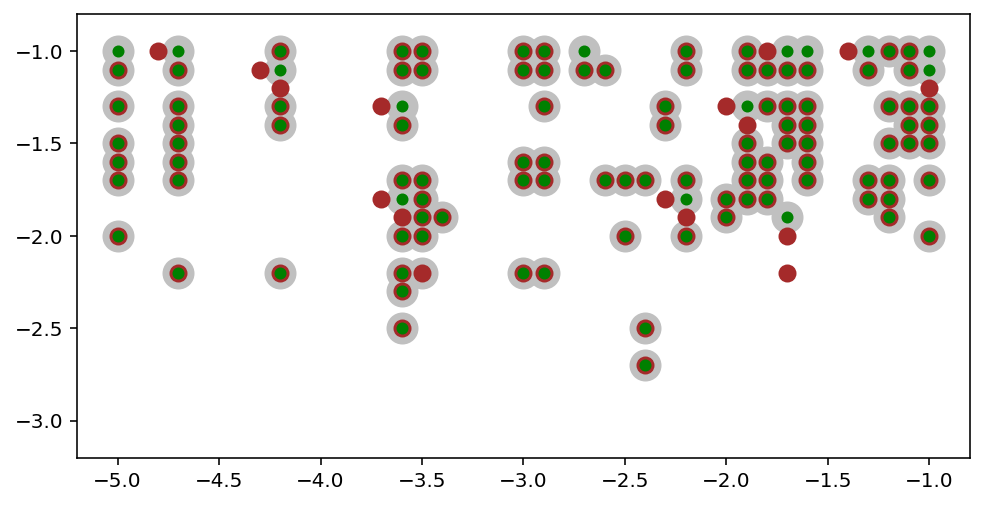

In [18]:
plt.figure(figsize=(8, 4), dpi=144)
plot_frame(783)


### NSGA-II

Давайте теперь временно закончим изобретать велосипеды и обратимся к широко известным алгоритмам. Один из таких алгоритмов - [NSGA-II](https://youtu.be/SL-u_7hIqjA), Non-dominated Sorting Genetic Algorithm.

Это nature-inspired алгоритм, который имитирует генетику. Зарождается случайная популяция аргументов (особей), которая начинает итеративно жить, скрещиваясь, подвергаясь мутациям и проходя естественный отбор через non-dominated сравнение (которое, напомню на всякий случай, является механизмом формирования Парето-фронта). Дополнительно ограничивается скученность (crowding), чтобы все особи не поселились в локальной области своего вымышленного мира.

Попробуем реализацию из [пакета pymoo](https://pymoo.org/algorithms/moo/nsga2.html).

In [19]:
import pymoo.algorithms.moo.nsga2
import pymoo.core.problem
import pymoo.optimize


In [20]:
class MyProblem(pymoo.core.problem.ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=2, n_obj=5, xl=[
            min_x0, min_x1], xu=[max_x0, max_x1])

    def _evaluate(self, x, out, *args, **kwargs):
        x = tuple(np.around(x, 1))
        f = x_to_f[x]

        # Инвертируем, т.к. pymoo всегда
        # оптимизирует в сторону минимума
        out["F"] = -f


Одна из странностей реализации `pymoo` - их алгоритм не формирует итоговый Pareto-фронт. Хотя на мой взгляд, именно это он и должен делать.

На гитхабе автор предлагает использовать [дополнительный код](https://github.com/anyoptimization/pymoo/issues/91#issuecomment-679026700), вот такой:

In [21]:
import pymoo.core.population
import pymoo.util.nds.non_dominated_sorting

pymoo_archive = pymoo.core.population.Population()


def pymoo_archive_update(pop):
    global pymoo_archive

    merged = pymoo.core.population.Population.merge(pymoo_archive, pop)

    I = pymoo.util.nds.non_dominated_sorting.NonDominatedSorting().do(
        merged.get('F'),
        only_non_dominated_front=True
    )

    pymoo_archive = merged[I]


Для визуализации будем сохранять историю популяций и эволюцию Pareto-фронта:

In [22]:
history_nsga_pop = []
history_nsga_front = []


Выполним 100 итераций с размером популяции 16 и посмотрим, что получится:

In [23]:
pymoo_problem = MyProblem()

pymoo_algo = pymoo.algorithms.moo.nsga2.NSGA2(pop_size=16)
pymoo_algo.setup(pymoo_problem, seed=12345)

for _ in range(0, 100):
    pymoo_algo.next()
    pymoo_result = pymoo_algo.result()

    pymoo_archive_update(pymoo_result.pop)

    history_nsga_pop.append(pymoo_result.X)
    history_nsga_front.append([-i.F for i in pymoo_archive])


In [24]:
def plot_frame_nsga(i):
    plot_frame_back()
    plt.scatter(*zip(*map(f_to_x, history_nsga_front[i])), c='blue', s=8*8)
    plt.scatter(*zip(*history_nsga_pop[i]), c='red', s=3*3)


In [25]:
ani = matplotlib.animation.FuncAnimation(
    plt.figure(figsize=(8, 4), dpi=720/8),
    plot_frame_nsga,
    frames=100,
    interval=500
)

html = ani.to_html5_video()
plt.close()


In [26]:
IPython.display.HTML(html)


Возникает вопрос, есть ли у этой красивой истории с хромосомами преимущества перед случайным поиском. На моих игрушечных данных небольшого размера это неочевидно.

Существенное отличие NSGA состоит в том, что этот алгоритм ограничивает размер популяции. Причём это даётся ценой более сложных вычислений (внутри есть сортировка по рангам и расстояниям). Думаю, это действительно важно, когда количество факторов исчисляется десятками и сотнями.

У NSGA есть вариации и ответвления, такие как [NSGA-III](https://pymoo.org/algorithms/moo/nsga3.html) и [AGE-MOEA](https://pymoo.org/algorithms/moo/age.html). На них тоже можно было бы посмотреть, но чувство меры и высота скроллбара подсказывают, что пора закругляться.

Этим я завершаю своё трехчастное эссе о методах многокритериальной оптимизации.